In [1]:
### Import libraries

%matplotlib inline
import xarray as xr
import cmocean as cmo
from glob import glob

import numpy as np
import numpy.ma as ma

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.path as mpath
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D

import cartopy
import cartopy.crs as ccrs

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [2]:
### Base path to files
base_path = '/nethome/5867800/'

# General settings and preparation

In [3]:
### Define functions for preparation of data and plotting

def divide_longitude(lons, lats, var):
    '''
    Split data into sections east and west of the prime meridian.
    
    Parameters:
    ---
    lons (array): longitudes
    lats (array): latitudes
    var (array): variable data associated with the latitudes and longitudes
        
    Returns:
    ---
    lons_greater (array): longitudes east of the prime meridian (0 to 180°)
    lons_lesser (array): longitudes west of the prime meridian (-180 to 0°)
    lats_greater (array): latitudes corresponding to lons_greater
    lats_lesser (array): latitudes corresponding to lons_lesser
    var_greater (array): variable data corresponding to lons_greater
    var_lesser (array): variable data corresponding to lons_lesser
    '''
    
    # Input Validation
    if not len(lons) == len(lats) == len(var):
        raise ValueError('Input arrays must have the same length')
    
    # Mask based on longitudes
    lons_greater = ma.masked_greater(lons, -0.01)
    lons_lesser = ma.masked_less(lons, 0.)
    
    lats_greater = ma.MaskedArray(lats, mask=lons_greater.mask)
    lats_lesser = ma.MaskedArray(lats, mask=lons_lesser.mask)
    
    var_greater = ma.MaskedArray(var, mask=lons_greater.mask)
    var_lesser = ma.MaskedArray(var, mask=lons_lesser.mask)
    
    return lons_greater, lons_lesser, lats_greater, lats_lesser, var_greater, var_lesser



def prepare_outline_ODP_plot(ax):
    '''
    Prepare map (boundaries, coastlines, gridlines) for detailed plotting around ODP Site 696.
    
    Parameters:
    ---
    ax : matplotlib axes object
        
    Returns:
    ---
    ax : modified matplotlib axes object with extent, coastlines, and gridlines
    '''
    
    # Set extent
    ax.set_extent([-60, -30, -78, -60], ccrs.PlateCarree())
    
    # Coastline
    ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=2)
    ax.scatter(1, -78.3, transform=ccrs.PlateCarree(), color='white', zorder=4, s=14)
    
    # Gridlines
    gl_configurations = [([-60], []),                   # 60W
                         ([-30], []),                   # 30 W
                         ([], np.arange(-80,-69,10)),   # 80, 70 S
                         ([], np.arange(-60,-59,10))]   # 60 S
    
    for i in range(3):
        gl = ax.gridlines(linestyle='--', linewidth=.7,
                          draw_labels=True, x_inline=False, y_inline=False,
                          crs=ccrs.PlateCarree(), zorder=5)
        
        gl.xlocator = mticker.FixedLocator(gl_configurations[i][0])
        gl.ylocator = mticker.FixedLocator(gl_configurations[i][1])
        
        # Position labels
        if i == 0:     # left side
            gl.right_labels  = False
            gl.bottom_labels = False
            gl.left_labels   = True
            gl.top_labels    = False
        elif i==1:     # top
            gl.right_labels  = False
            gl.bottom_labels = False
            gl.left_labels   = False
            gl.top_labels    = True
            gl.rotate_labels = False
        elif i == 2:   # right side
            gl.right_labels  = True
            gl.bottom_labels = False
            gl.left_labels   = False
            gl.top_labels    = False
            gl.rotate_labels = False
        else:         # line
            gl.right_labels  = False
            gl.bottom_labels = False
            gl.left_labels   = False
            gl.top_labels    = False
            
        gl.xlabel_style = {'size': 12}
        gl.ylabel_style = {'size': 12}
    
    return ax


def prepare_outline_SPS_plot(ax):
    '''
    Prepare map (boundaries, coastlines, gridlines) for plotting with South Polar Stereo projection.
    
    Parameters:
    ---
    ax : matplotlib axes object
        
    Returns:
    ---
    ax : modified matplotlib axes object with exent, circular boundary, coastlines, ODP Site 696 and gridlines
    '''
    
    # Set extent and boundary
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Coastline
    ax.contour(lons[:760,:], lats[:760,:], bath[:760,:], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=3)
    
    # ODP Site 696
    ax.plot(x696_le, y696_le, color='r', marker='*', markersize=10, markeredgecolor='black', markeredgewidth=.5,
            transform=ccrs.PlateCarree(), zorder=2)
    
    # Gridlines
    ax.gridlines(linestyle='--')
    
    return ax



def prepare_outline_map_plot(ax):
    '''
    Prepare map (boundaries, coastlines, gridlines) for detailed plotting around ODP Site 696.
    
    Parameters:
    ---
    ax : matplotlib axes object
        
    Returns:
    ---
    ax : modified matplotlib axes object with extent, coastlines, bathymetry, and gridlines
    gl_adapt1 : adapted gridlines object to be modified during plotting
    gl_adapt2 : adapted gridlines object to be modified during plotting
    gl_adapt3 : adapted gridlines object to be modified during plotting
    '''
    
    # Set extent
    ax.set_extent([-60, 40, -90, -55], ccrs.PlateCarree())
    
    # Coastline
    cl = ax.contour(lons[:,875:2550], lats[:,875:2550], bath[:,875:2550], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=3)
    for c in cl.collections:   # rasterize
        c.set_rasterized(True)
    ax.scatter(1, -78.4, transform=ccrs.PlateCarree(), color='white', zorder=4, s=37)
    
    # Bathymetry
    bl = ax.contour(lons[:,875:2550], lats[:,875:2550], bath[:,875:2550], levels=clevels, transform=ccrs.PlateCarree(), colors='k',
               linewidths=0.5, alpha=0.5, linestyles='-', zorder=1)
    for c in bl.collections:   # rasterize
        c.set_rasterized(True)
    
    
    # Gridlines
    gl_configurations = [(np.arange(-60, 65,120), []),      # 60 W, 60 E
                         (np.arange( 0,   5, 60), []),      # 0 W/E
                         (np.arange(-30, 35, 60), []),      # 30 W, 30 E
                         ([], np.arange(-60,-50, 10)),      # 60 S
                         ([], np.arange(-90,-69, 10)),      # 80 S, 70 S
                         ([], [-85, -75, -65, -55, -50])]   # 85, 75, 65, 55, 50 S (only lines)
    
    for i in range(len(gl_configurations)):
        gl = ax.gridlines(linestyle='--', linewidth=.7,
                          draw_labels=True, x_inline=False, y_inline=False,
                          crs=ccrs.PlateCarree(), zorder=7)
        
        gl.xlocator = mticker.FixedLocator(gl_configurations[i][0])
        gl.ylocator = mticker.FixedLocator(gl_configurations[i][1])
        
        # Position labels
        if i < 3:     # along sides and top
            gl.right_labels  = True
            gl.bottom_labels = False
            gl.left_labels   = True
            gl.top_labels    = True
        elif i > 4:   # lines
            gl.right_labels  = False
            gl.bottom_labels = False
            gl.left_labels   = False
            gl.top_labels    = False
        else:         # along bottom
            gl.right_labels  = False
            gl.bottom_labels = True
            gl.left_labels   = False
            gl.top_labels    = False
        
        if i in [1, 2, 4]:   # 0 W/E, 30 W/E, 80/70 S, 60 S
            gl.rotate_labels = False
        if i in [1, 2]:      # 0 W/E, 30 W/E, 60 S
            gl.ylabel_style = {'rotation': 45}
        if i == 3:
            gl.ylabel_style = {'rotation':-90}
        gl.xlabel_style = {'size': 12}
        gl.ylabel_style = {'size': 12}
        
        # Remove double coordinate labels
        if i == 4:
            gl_adapt1 = gl
        if i == 3:
            gl_adapt2 = gl
        if i == 0:
            gl_adapt3 = gl
    
    return ax, gl_adapt1, gl_adapt2, gl_adapt3

In [4]:
### Settings circular boundary South Polar Stereo projection plot
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [5]:
### Locations

# ODP Site 696
x696_pd, y696_pd = -42.933067, -61.849083   # present-day coordinates [°]
x696_le, y696_le = -57., -67.5              # late Eocene coordinates (determined visually) [°]

## Release locations
# Forwards [°]
lons_fw = np.array([-55., -50., -45., -40., -35.,
                    -30., -25., -20., -15., -10.,
                     -5.,   0.,   5.,  10.,  15.,
                     20.,  25.,  30.,  35.,  40.,
                     45.,  50.,  55.,  60., -57.82330253])
lats_fw = np.array([-77.99537227, -78.45787684, -79.17977465, -79.75459498, -79.99027112,
                    -80.07689735, -79.9997914 , -80.12097168, -79.24559138, -78.39033646,
                    -77.33178711, -76.13251966, -75.17986379, -74.68456009, -73.6896764 ,
                    -73.53134648, -72.9724492 , -72.3117251 , -72.29006817, -72.16268516,
                    -70.86573029, -68.58359528, -68.58359528, -66.59729004, -77.])
# Backwards [°]
lons_bw = np.array([-57.04998779, -57.0249939,  -57.,         -56.9750061,  -56.95001221,
                    -57.04998779, -57.0249939,  -57.,         -56.9750061,  -56.95001221,
                    -57.04998779, -57.0249939,  -57.,         -56.9750061,  -56.95001221,
                    -57.04998779, -57.0249939,  -57.,         -56.9750061,  -56.95001221,
                    -57.04998779, -57.0249939,  -57.,         -56.9750061,  -56.95001221])
lats_bw = np.array([-67.5270462,  -67.5270462,  -67.5270462,  -67.5270462,  -67.5270462,
                    -67.5164814,  -67.5164814,  -67.5164814,  -67.5164814,  -67.5164814,
                    -67.5059166,  -67.5059166,  -67.5059166,  -67.5059166,  -67.5059166,
                    -67.49535179, -67.49535179, -67.49535179, -67.49535179, -67.49535179,
                    -67.48478699, -67.48478699, -67.48478699, -67.48478699, -67.48478699])

In [6]:
### Prepare bathymetric data

# Load data Nooteboom et al. (2022)
topo = xr.open_dataset(base_path + 'grid/adapted_bathymetry.nc')

# Load latitudes, longitudes and bathymetry
lonsg, lonsl, latsg, latsl, varg, varl = divide_longitude(topo.variables['T_LON_2D'][:,:], topo.variables['T_LAT_2D'][:,:],
                                                          topo.variables['Bathymetry'][:,:])
lons = np.concatenate((lonsg[:,2650:], lonsg[:,:850], lonsl[:,850:2650]), axis=1)   # -179.95 to -85.05, -84.95 to -0.05, 0.05 to 179.95
lats = np.concatenate((latsg[:,2650:], latsg[:,:850], latsl[:,850:2650]), axis=1)
bath = np.concatenate((varg[:,2650:], varg[:,:850], varl[:,850:2650]), axis=1)

# Other figures

This notebook contains the code to compose the following figures:
- Map of coastal regions and release locations
- Maps of mean forcing model fields
- Map of used locations of ODP Site 696
- Zoom-in comparison of trajectories iceberg classes C4 and C5
- Longitudinal reach of iceberg trajectories

In [7]:
### Define levels used for contours and bathymetry
clevels = [-6000, -5500, -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -750, -500, -250, 0]
cnorm = BoundaryNorm(clevels, ncolors=(len(clevels)-1), clip=False)
blevels = range(-6000, 1, 100)

Calculate mean forcing model fields over the five-year model period. (Data from Nooteboom et al., 2022)

In [8]:
### Load data
data_path_ocean_POP = '/storage/shared/pop/p21a.EO38Ma.tx0.1.2pic_control/daily/'

files = sorted(glob(data_path_ocean_POP+'vars_first600m_eocene_2pic_pop_00*.nc'))

filename = data_path_ocean_POP+'vars_first600m_eocene_2pic_pop_00400301.nc'   # remove empty field from calculations
for i, name in enumerate(files):
    if name == filename:
        files.pop(i)

In [9]:
### Prepare data

# Define arrays for ocean velocities (u and v) and temperature
uvel = np.zeros((1050,3600))
vvel = np.zeros_like(uvel)
temp = np.zeros((14,1050,3600))

# Sum variables at the Southern Hemisphere for each timestep
for file in files:
    dat = xr.open_dataset(file)
    uvel += dat['UVEL'][0,0,:1050,:]     # at ocean surface
    vvel += dat['VVEL'][0,0,:1050,:]     # ""
    temp += dat['TEMP'][0,:14,:1050,:]   # until ~200 m depth

# Calculate temporal mean values
uvel = uvel/len(files)
vvel = vvel/len(files)
temp = temp/len(files)

# Calculate mean over the first 200 m depth for temperature
temp = temp.mean(dim='depth')

# Align grids
_, _, _, _, varg, varl = divide_longitude(topo.variables['T_LON_2D'][:1050,:], topo.variables['T_LAT_2D'][:1050,:], uvel)
uvel = np.concatenate((varg[:,2650:], varg[:,:850], varl[:,850:2650]), axis=1)   # -179.95 to -85.05, -84.95 to -0.05, 0.05 to 179.95
_, _, _, _, varg, varl = divide_longitude(topo.variables['T_LON_2D'][:1050,:], topo.variables['T_LAT_2D'][:1050,:], vvel)
vvel = np.concatenate((varg[:,2650:], varg[:,:850], varl[:,850:2650]), axis=1)
_, _, _, _, varg, varl = divide_longitude(topo.variables['T_LON_2D'][:1050,:], topo.variables['T_LAT_2D'][:1050,:], temp)
temp = np.concatenate((varg[:,2650:], varg[:,:850], varl[:,850:2650]), axis=1)

# Calculate ocean surface velocity
vel = np.sqrt(uvel**2 + vvel**2)/100.

# Select marine domain (land is given zero values)
velm = np.ma.masked_where(vel <= 0, vel)
tempm = np.ma.masked_where(temp <= 0, temp)

## Regions and release locations

Construct a figure showing the positions of the defined release locations (forwards and backwards), the reconstructed position of ODP Site 696, the coastal regions as defined by Carter et al. (2014), and the potential regions of ice formation from Baatsen et al. (2024).

First, load and prepare the bathymetric data and the defined coastal regions.

In [10]:
### Load data
regs = xr.open_dataset(base_path + 'grid/bathymetry_regions.nc')

### Prepare data: split around meridian for plotting and select regions from Palmer Land to Dronning Maud Land
_, _, _, _, regg, regl = divide_longitude(regs['U_LON_2D'].values, regs['U_LAT_2D'].values, regs['region'].where(regs['region']>1.5).values)

We also require the climate indices as defined by Baatsen et al. (2024), specifically the glacial index.

In [11]:
### Load data
datMB = xr.open_dataset(base_path + '/grid/38Ma_2PIC_CI_Antarctica.nc')

### Prepare data
# Select terrestrial region
ice = datMB.where(datMB['Z']>0.)

# Select where dominant glacial index
ice['II'] = ice['II'].where((ice['II']>ice['MI']) & (ice['II']>ice['VI']))
# ice['II'] = tmp.where(tmp>ice['VI'])

In [12]:
### Set colours
cols_carter = colors.ListedColormap(['#94cff5','#d2d3d4','#ada4ce','#e5a787','#cc393c','#d578aa','#d6c7d0']) # colourscheme from regions used in Carter et al. (2014)
cm_ice = LinearSegmentedColormap.from_list('Glacial', ['#B2E5FF', '#0F6B99'], N=15)                          # colormap glacial Baatsen et al. (2024)

Main text: Fig. 2a

Start plotting...
Base plotted, continue with data main figure...
Main figure finished, continue with inset...


/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Saving figure...


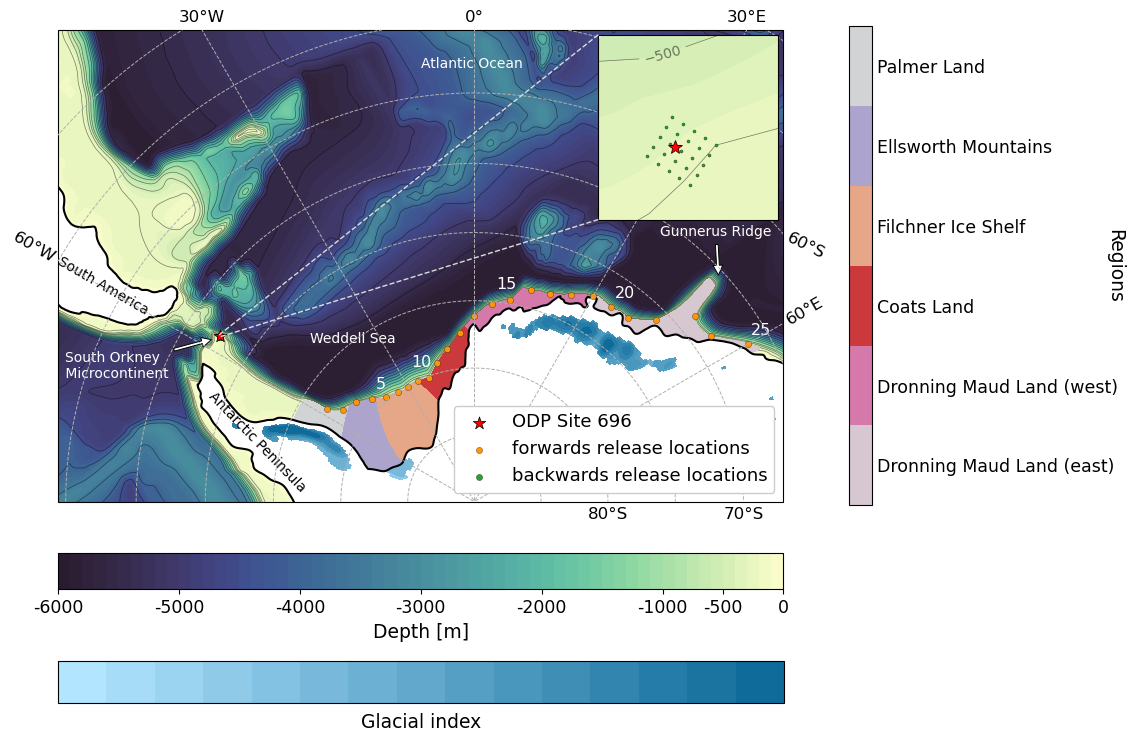

In [13]:
### Plot map

### General settings figure
print(f'Start plotting...')
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)}, figsize=(12,8.4))
ax, gl_adapt, gl_adapt2, gl_adapt3 = prepare_outline_map_plot(ax)

print(f'Base plotted, continue with data main figure...')


### Plot main figure
# Bathymetry
cc = ax.contourf(lons[:,875:2550], lats[:,875:2550], bath[:,875:2550], levels=blevels, cmap=cmo.cm.deep_r,
                 transform=ccrs.PlateCarree(), zorder=0)
for c in cc.collections:   # rasterise
    c.set_rasterized(True)
# Add colorbar
cbar = plt.colorbar(cc, ax=ax, orientation='horizontal', pad=-.15, shrink=0.78, anchor=(0.0,0.0),
                    spacing='proportional', ticks=[-6000,-5000,-4000,-3000,-2000,-1000,-500,0])
cbar.set_label('Depth [m]', size=13.5)
cbar.ax.set_xticklabels(['-6000', '-5000', '-4000', '-3000', '-2000', '-1000', '-500', '0'], fontsize=12.5)

# Climate indices (Baatsen et al., 2024)
cc = ax.contourf(ice['lon'][:], ice['lat'][:], ice['II'][:,:], cmap=cm_ice, norm=colors.Normalize(vmin=0, vmax=1), 
                transform=ccrs.PlateCarree(), zorder=0)
for c in cc.collections:   # rasterise
    c.set_rasterized(True)
# Add colorbar
cax = plt.axes([0.125, -.025, 0.605, 0.05])
cb = mpl.colorbar.ColorbarBase(cax, orientation='horizontal', cmap=cm_ice, ticks=[0,1])
cb.set_label('Glacial index', size=13.5)
cb.set_ticks([])

# ODP Site 696
ax.scatter(x696_le, y696_le, color='red', marker='*', s=90, edgecolors='black', linewidths=.5, transform=ccrs.PlateCarree(),
           zorder=6, label='ODP Site 696')

# Release locations
ax.scatter(lons_fw, lats_fw, transform=ccrs.PlateCarree(), color='xkcd:tangerine', zorder=5,
           label='forwards release locations',s=20, edgecolor='k', linewidths=0.2)
ax.scatter(lons_bw, lats_bw, transform=ccrs.PlateCarree(), color='tab:green', zorder=5,
           label='backwards release locations',s=20, edgecolor='k', linewidths=0.2)
ax.text(lons_fw[3]-1.2, lats_fw[3]+1,    '5', transform=ccrs.PlateCarree(), color='white', fontsize=11.5)
ax.text(lons_fw[8]-10,  lats_fw[8]+.4,  '10', transform=ccrs.PlateCarree(), color='white', fontsize=11.5)
ax.text(lons_fw[13]-4,  lats_fw[13]+.6, '15', transform=ccrs.PlateCarree(), color='white', fontsize=11.5)
ax.text(lons_fw[18]-.5, lats_fw[18]+.7, '20', transform=ccrs.PlateCarree(), color='white', fontsize=11.5)
ax.text(lons_fw[23]-1,  lats_fw[23]+.5, '25', transform=ccrs.PlateCarree(), color='white', fontsize=11.5)

# Release regions
im2 = ax.contourf(lonsg[:825,:], latsg[:825,:], regg[:825,:], levels=[0,1,2,3,4,5,6,7],
                  cmap=cols_carter, transform=ccrs.PlateCarree(), zorder=2)
ax.contourf(lonsl[:825,:], latsl[:825,:], regl[:825,:], levels=[0,1,2,3,4,5,6,7],
            cmap=cols_carter, transform=ccrs.PlateCarree(), zorder=2)
cbar2 = plt.colorbar(im2, ax=ax, orientation='vertical', pad=.07, shrink=0.74)
cbar2.set_label('Regions', size=13.5, rotation=-90)
cbar2.ax.set_ylim(1, 7)
cbar2.set_ticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
cbar2.set_ticklabels(['Palmer Land', 'Ellsworth Mountains', 'Filchner Ice Shelf', 'Coats Land', 'Dronning Maud Land (west)',
                      'Dronning Maud Land (east)'], fontsize=12.5)
cbar2.ax.tick_params(size=0)
cbar2.ax.invert_yaxis()

# Names
ax.text(-66, -56.5, 'South America', transform=ccrs.PlateCarree(), color='k', fontsize=10, rotation=-30)
ax.text(-7, -58, 'Atlantic Ocean', transform=ccrs.PlateCarree(), color='white', fontsize=10)
ax.text(-46, -73, 'Weddell Sea', transform=ccrs.PlateCarree(), color='white', fontsize=10)
ax.text(-88, -70, 'Antarctic Peninsula', transform=ccrs.PlateCarree(), color='k', fontsize=10, rotation=-46)
transform = ccrs.PlateCarree()._as_mpl_transform(ax)
ax.annotate('South Orkney \n Microcontinent', xy=(x696_le-1, y696_le+0.25), xycoords=transform, xytext=(-71,-62), ha='center',
            color='white', fontsize=10, arrowprops=dict(arrowstyle='simple, head_width=.7, head_length=.7', facecolor='white', edgecolor='k', lw=.7))
ax.annotate('Gunnerus Ridge', xy=(47.5, -65.5), xycoords=transform, xytext=(35,-66),
            color='white', fontsize=10, arrowprops=dict(arrowstyle='simple, head_width=.7, head_length=.7', facecolor='white', edgecolor='k', lw=.7))

print(f'Main figure finished, continue with inset...')


### Create an inset figure
sub_ax = fig.add_axes([0.575, 0.55, 0.15, 0.22], projection=ccrs.SouthPolarStereo(central_longitude=-0))
sub_ax.set_extent([-57.1,-56.8,-67.55,-67.45], ccrs.PlateCarree())
# Bathymetry
sub_ax.contourf(lons[407:413,1227:1234], lats[407:413,1227:1234], bath[407:413,1227:1234], levels=range(-6000,1,100),
                     cmap=cmo.cm.deep_r, transform=ccrs.PlateCarree())
lc = sub_ax.contour(lons[407:413,1227:1234], lats[407:413,1227:1234], bath[407:413,1227:1234],
                    levels=clevels, linewidths=0.5, alpha=0.5, colors='k', linestyles='-', transform=ccrs.PlateCarree())
sub_ax.clabel(lc, levels=[-500], inline=True)
# Coastlines
sub_ax.contour(lons[407:413,1227:1234], lats[407:413,1227:1234], bath[407:413,1227:1234], levels=[0], transform=ccrs.PlateCarree(), colors='k')
# Release locations
sub_ax.scatter(lons_bw, lats_bw, color='tab:green', marker='.', s=20, transform=ccrs.PlateCarree(), zorder=10, edgecolor='k', linewidths=0.2)
# ODP 696
sub_ax.plot(x696_le, y696_le, color='red', marker='*', markersize=10, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(),
            zorder=15)

### Draw lines to inset
axes = mark_inset(ax, sub_ax, loc1=2, loc2=3, edgecolor='gainsboro', linestyle='dashed', linewidth=1, zorder=4)

ax.legend(loc='lower right', fontsize=13, facecolor='white', framealpha=1).set_zorder(7)
plt.draw()

### Fix coordinate labels
for j, ea in enumerate(gl_adapt.label_artists):
    if '-' in str(ea[2]):
        ea[2].set_color('white')
    if '-' not in str(ea[2]):
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])

for j, ea in enumerate(gl_adapt2.label_artists):
    if '-' in str(ea[2]):
        ea[2].set_color('white')
    if '-' not in str(ea[2]):
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])

for j, ea in enumerate(gl_adapt3.label_artists):
    if j<1:
        ea[2].set_color('white')
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])
    else:
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])

print(f'Saving figure...')


plt.savefig('figures/Paper/F02aMap.pdf', dpi=300, bbox_inches = 'tight')
plt.show()

## Mean fields

Study the mean model fields around Antarctica from the late Eocene model and compare modelled temperatures to proxy data. 

In [14]:
### Load proxy data
# Present-day locations
proxy_sites = ['ODP 1172', 'Seymour Island', 'DSDP 511', 'ODP 1170', 'ODP 1090', 'ODP 1168', 'ODP 696']
proxy_lons = [149.56, -56.17, -46.58, 146.05, 8.54, 144.40, x696_pd]
proxy_lats = [-43.58, -64.17, -51.00, -47.15, -42.55, -42.60, y696_pd]

# Eocene locations
proxy_lonsE = [157.5, -63., -36., 153., 11., 150., x696_le]
proxy_latsE = [-58., -69., -59., -59., -51.5, -57.5, y696_le]

# Temperatures
proxy_TEX86 = [17.57, 15.27, 18.17, 17.54, 19.84, 23.55, 16.59]    # 0-200m
proxy_TEX86H = [22.18, 19.30, 22.93, 22.15, 25.02, 29.66, 20.95]   # 0m
proxy_SST = [23.9, 15, 20]                                         # only available for first three sites

# Ages: 38-36, 38-36, 37-36, 39-38, 37-36, 37-36, 37-35

Fig. 2.2b

In [15]:
### Settings
vals = [velm, tempm]
labelsz = ['Mean surface velocity [m/s]', 'Mean surface temperature [°C]']
cmaps = [cmo.cm.speed, cmo.cm.thermal]
vmaxes = [0.4, 25]

Start plotting...
Saving figure...


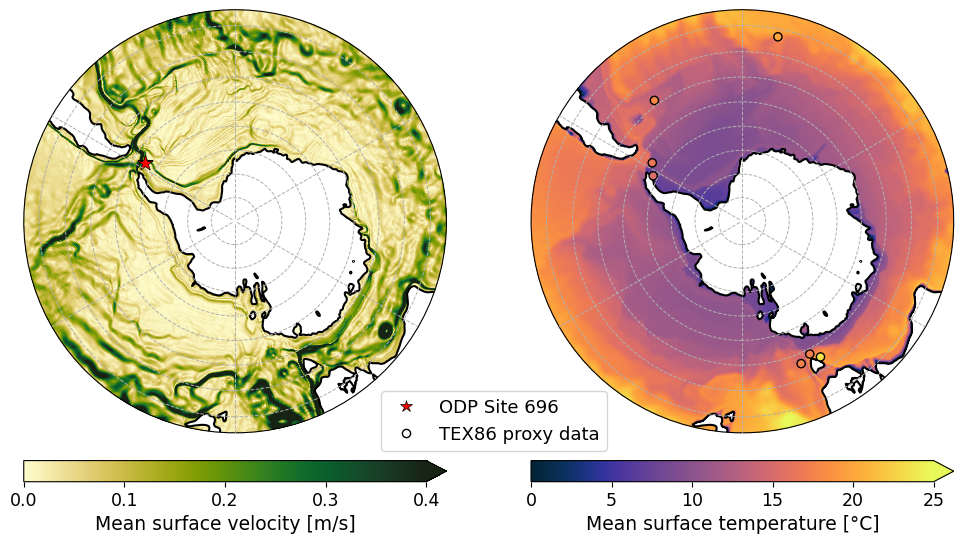

In [16]:
### Plot map

### General settings figure
print(f'Start plotting...')
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)}, figsize=(12,7.2))

for val, label, vm, cmap, ax in zip(vals, labelsz, vmaxes, cmaps, axes):
    ax.set_extent([-180,180,-90,-47], ccrs.PlateCarree())

    ### Gridlines
    # W/E
    gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
    gl0.xlocator = mticker.FixedLocator(np.arange(-180,180,60))
    gl0.ylocator = mticker.FixedLocator([])
    gl0.right_labels = False
    gl0.bottom_labels = False
    gl0.left_labels = False
    gl0.top_labels = False

    # S
    gl2 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
    gl2.xlocator = mticker.FixedLocator([])
    gl2.ylocator = mticker.FixedLocator(np.arange(-90,-25,5))
    gl2.right_labels = False
    gl2.bottom_labels = False
    gl2.left_labels = False
    gl2.top_labels = False
    gl2.rotate_labels = False
    
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ### Plot main figure
    # Coastlines
    km = ax.contour(lons[:1050,:], lats[:1050,:], bath[:1050,:], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=3)
    for e in km.collections: # rasterise
        e.set_rasterized(True)
    ax.scatter(1, -78.3, transform=ccrs.PlateCarree(), color='white', zorder=4, s=11)
    
    # ODP 696
    if label!='Mean surface temperature [°C]':
        ax.scatter(x696_le, y696_le, color='r', marker='*', s=140, edgecolors='k', linewidths=.5, transform=ccrs.PlateCarree(), zorder=6)
  
    # Plot model data
    ax.pcolormesh(lons[:1050,:], lats[:1050,:], val[:,:], transform=ccrs.PlateCarree(), vmin=0., vmax=vm, cmap=cmap, rasterized=True)
    im = ax.pcolormesh(lons[:1050,:], lats[:1050,:], val[:,:], transform=ccrs.PlateCarree(), vmin=0., vmax=vm, cmap=cmap, rasterized=True)
    # Add colorbar
    cb = fig.colorbar(im, ax=ax, orientation='horizontal', pad=.05, extend='max')
    cb.set_label(label, size=13.5)
    cb.ax.tick_params(axis='x', which='both', labelsize=12.5)

    # Plot temperature proxy data
    if label=='Mean surface temperature [°C]':
        sc = ax.scatter(proxy_lonsE, proxy_latsE, c=proxy_TEX86, transform=ccrs.PlateCarree(), vmin=0, vmax=vm,
                        s=35, cmap=cmap, edgecolors='k', zorder=6)

# Legend
handles, labels = ax.get_legend_handles_labels()
ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(75),
             markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
handles.append(ODP)
prx = Line2D([0], [0], label='TEX86 proxy data', marker='o', markersize=np.sqrt(35),
             markeredgecolor='k', markerfacecolor='None', markeredgewidth=1., linestyle='')
handles.append(prx)
ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.2, 0.12), fontsize=13)

print(f'Saving figure...')
plt.savefig('figures/Paper/F02bcModelfields.pdf', dpi=300, bbox_inches='tight')
plt.show()

## ODP locations

In the supplementary simulations, the effect of inducing a southwestward shift in the position of ODP Site 696 on the iceberg trajectories is studied. Below, the used positions of ODP Site 696 are shown with respect to the bathymetry and surface flow field.

Supplements: Figure S4.1

Saving figure...


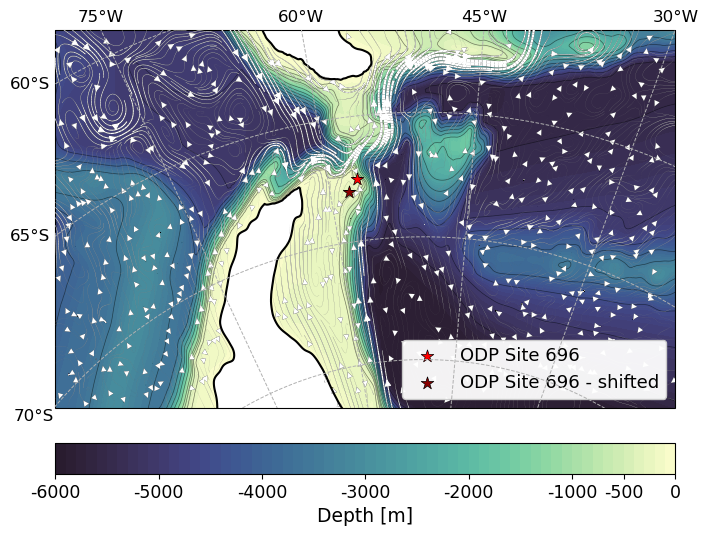

In [17]:
### Plot fields and icebergs
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=-50)}, figsize=(8,9))
ax.set_extent([-80., -30., -75., -60.])

### Gridlines
gl_configurations = [(np.arange(-75,-25,15), []),   # -75, -60, -45, -30 W
                     ([], np.arange(-80,-70,5)),    # 75 S
                     ([], np.arange(-70,-59,5))]    # 70, 65, 60 S

for i in range(3):
    gl = ax.gridlines(linestyle='--', linewidth=.7,
                      draw_labels=True, x_inline=False, y_inline=False,
                      crs=ccrs.PlateCarree(), zorder=6)

    gl.xlocator = mticker.FixedLocator(gl_configurations[i][0])
    gl.ylocator = mticker.FixedLocator(gl_configurations[i][1])

    # Position labels
    if i == 0:   # top
        gl.right_labels  = False
        gl.bottom_labels = False
        gl.left_labels   = False
        gl.top_labels    = True
        gl.rotate_labels = False
    elif i == 1: # line
        gl.right_labels  = False
        gl.bottom_labels = False
        gl.left_labels   = False
        gl.top_labels    = False
    else:       # left side
        gl.right_labels  = False
        gl.bottom_labels = True
        gl.left_labels   = True
        gl.top_labels    = False
        gl.rotate_labels = False
    
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}


### Plot main figure
# Coastlines
ax.contour(lons[:650,800:1700], lats[:650,800:1700], bath[:650,800:1700], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=4)   # coastlines

# Bathymetry
ax.contour(lons[:650,800:1700], lats[:650,800:1700], bath[:650,800:1700], levels=clevels, linewidths=0.5, alpha=0.5, colors='k', linestyles='-', transform=ccrs.PlateCarree(), zorder=1)
cc = ax.contourf(lons[:650,800:1700], lats[:650,800:1700], bath[:650,800:1700], levels=blevels, cmap=cmo.cm.deep_r, transform=ccrs.PlateCarree(), zorder=0)
for c in cc.collections:   # rasterise
    c.set_rasterized(True)
# Add colorbar
cbar = plt.colorbar(cc, ax=ax, orientation='horizontal', shrink=1, pad=.05,
                    spacing='proportional', ticks=[-6000,-5000,-4000,-3000,-2000,-1000,-500,0])
cbar.set_label('Depth [m]', size=13.5)
cbar.ax.set_xticklabels(['-6000', '-5000', '-4000', '-3000', '-2000', '-1000', '-500', '0'], fontsize=12.5)

# ODP Site 696
ax.scatter(x696_le, y696_le, color='red', marker='*', s=90, edgecolors='k', linewidths=.5, transform=ccrs.PlateCarree(), zorder=5, label='ODP Site 696')
ax.scatter(x696_le-1., y696_le-0.5, color='darkred', marker='*', s=90, edgecolors='k', linewidths=.5, transform=ccrs.PlateCarree(), zorder=5, label='ODP Site 696 - shifted')

### Mean ocean surface velocity
lw = 5.05 * np.sqrt((uvel[:650,800:1700])**2+(vvel[:650,800:1700])**2) / 200.
ax.streamplot(lons[:650,800:1700], lats[:650,800:1700], uvel[:650,800:1700], vvel[:650,800:1700], transform=ccrs.PlateCarree(),
              linewidth=lw, density=5, color='black', zorder=2)
lw = 5 * np.sqrt((uvel[:650,800:1700])**2+(vvel[:650,800:1700])**2) / 200.
ax.streamplot(lons[:650,800:1700], lats[:650,800:1700], uvel[:650,800:1700], vvel[:650,800:1700], transform=ccrs.PlateCarree(),
              linewidth=lw, density=5, color='white', zorder=3)

ax.legend(fontsize=13, loc='lower right', framealpha=.95)
plt.draw()

### Fix coordinate labels
for i, ea in enumerate(gl.label_artists):
    if '-' not in str(ea[2]):
        ea[2].set_color('white')
        pos = ea[2].get_position()
        ea[2].set_position([pos[0]-500000., pos[1]])
    else:
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])
    if i == 0:
        pos = ea[2].get_position()
        ea[2].set_position([pos[0]-100000, pos[1]+10000])

print(f'Saving figure...')
plt.savefig('figures/Paper/FS01ODPs.png', dpi=300, bbox_inches='tight') # streamlines are bold when saving to PDF
plt.show()

## Longitudinal reach

Study whether it is possible for particles to travel around Antarctica and reach ODP Site 696 that way within the timespan of the model (five years). Perform a simulation with passive particles without the delete particles kernel to leave particles in the model and study their trajectories.

Supplements: Figure S4.3

In [18]:
### Load data
FW_circ = xr.open_zarr(base_path + 'passive/20p_5y_30d_1dt_2yr_circ.zarr')          # circumpolar (forwards)

Plot trajectories:

Saving figure...


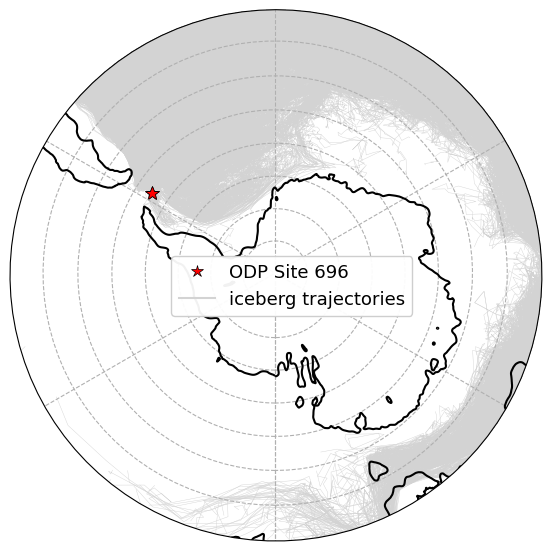

In [19]:
### Plot forwards trajectories
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)}, figsize=(6.9,6.9))

# Setup axes
ax = prepare_outline_SPS_plot(ax)

# Trajectories
ax.plot(FW_circ['lon'].T, FW_circ['lat'].T, transform=ccrs.Geodetic(), linewidth=.3, zorder=0, color='lightgrey', rasterized=True)

# ODP Site 696
ax.plot(x696_le, y696_le, color='r', marker='*', markersize=10, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree())

# Legend
handles, labels = ax.get_legend_handles_labels()
ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(75),
             markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
handles.append(ODP)
oth = Line2D([0], [0], label='iceberg trajectories', color='lightgrey')
handles.append(oth)
ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.53,0.48), fontsize='13', framealpha=.95)

print('Saving figure...')
plt.savefig(f'figures/Paper/FS02aFWTrajectoriesCirc.pdf', bbox_inches='tight', dpi=300)
plt.show()

Show release locations:

Saving figure...


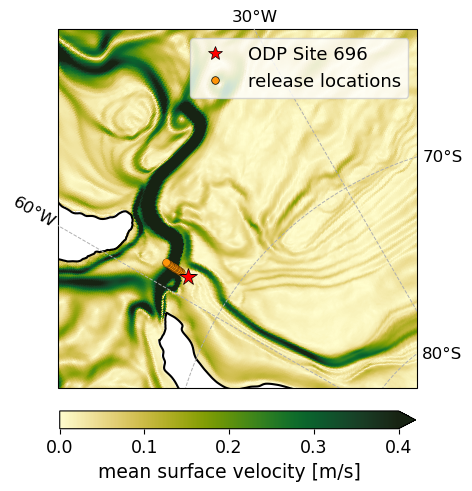

In [20]:
### Plot forwards release locations
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.SouthPolarStereo()}, figsize=(5.1,5.83))

# Setup axes
ax = prepare_outline_ODP_plot(ax)

# Velocity field
im = ax.pcolormesh(lons[80:700,1000:1700], lats[80:700,1000:1700], velm[80:700,1000:1700], transform=ccrs.PlateCarree(), vmin=0., vmax=.4, cmap=cmo.cm.speed, rasterized=True)
# Add colorbar
cb = fig.colorbar(im, ax=ax, orientation='horizontal', pad=.05, extend='max', shrink=.9, ticks=[0.0, 0.1, 0.2, 0.3, 0.4])
cb.set_label('mean surface velocity [m/s]', size=13.5)
cb.ax.set_xticklabels(['0.0', '0.1', '0.2', '0.3', '0.4'], fontsize=12.5)

# Plot ODP 696
ax.plot(x696_le, y696_le, color='r', marker='*', markersize=13, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(), zorder=4)

# Plot release locations
ax.scatter(np.linspace(-57., -57., num=20, endpoint=True), np.linspace(-67., -66., num=20, endpoint=True),
           transform=ccrs.PlateCarree(), color='xkcd:tangerine', zorder=3, s=30, edgecolor='k', linewidths=0.2)

# Legend
handles, labels = ax.get_legend_handles_labels()
ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(100),
             markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
handles.append(ODP)
rel = Line2D([0], [0], label='release locations', marker='o', markersize=np.sqrt(30),
             markeredgecolor='k', markerfacecolor='xkcd:tangerine', markeredgewidth=.5, linestyle='')
handles.append(rel)
ax.legend(handles=handles, loc='upper right', fontsize='13')

print('Saving figure...')
plt.savefig(f'figures/Paper/FS02bFWLocationsCirc.pdf', bbox_inches='tight', dpi=300)
plt.show()